In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
import pandas as pd
import numpy as np
import missingno as msno
import re
import datetime

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('data/startup_funding.csv')

# View the first few rows
df.head()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
0,1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,"20,00,00,000",NaN
1,2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,"80,48,394",NaN
2,3,09/01/2020,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,"1,83,58,860",NaN
3,4,02/01/2020,https://www.wealthbucket.in/,FinTech,Online Investment,New Delhi,Vinod Khatumal,Pre-series A,"30,00,000",NaN
4,5,02/01/2020,Fashor,Fashion and Apparel,Embroiled Clothes For Women,Mumbai,Sprout Venture Partners,Seed Round,"18,00,000",NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Sr No              3044 non-null   int64 
 1   Date dd/mm/yyyy    3044 non-null   object
 2   Startup Name       3044 non-null   object
 3   Industry Vertical  2873 non-null   object
 4   SubVertical        2108 non-null   object
 5   City  Location     2864 non-null   object
 6   Investors Name     3020 non-null   object
 7   InvestmentnType    3040 non-null   object
 8   Amount in USD      2084 non-null   object
 9   Remarks            419 non-null    object
dtypes: int64(1), object(9)
memory usage: 237.9+ KB


# **Data Preprocessing**

<Axes: >

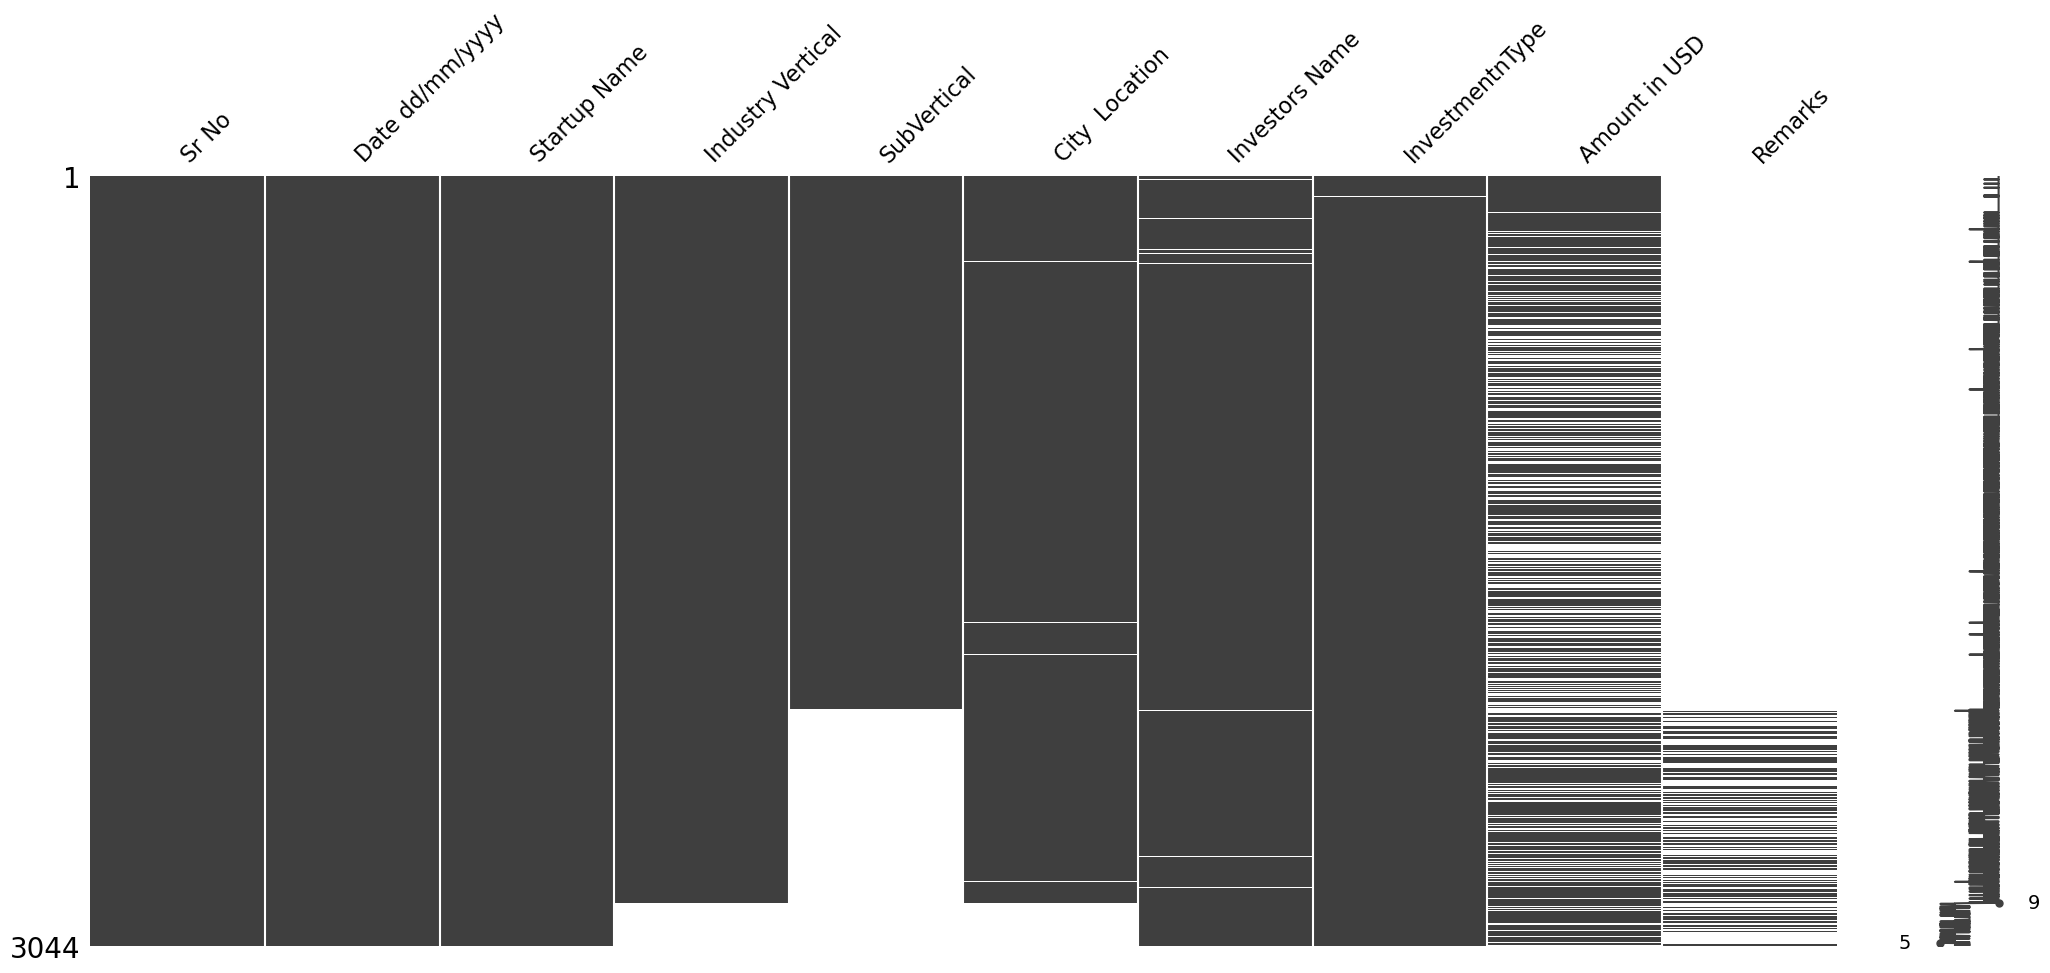

In [5]:
import missingno as msno
msno.matrix(df)

In [6]:
# Standardize column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

# Fixing date column
df['date_dd/mm/yyyy'] = df['date_dd/mm/yyyy'].str.replace('05/072018','05/07/2018')
df['date_dd/mm/yyyy'] = df['date_dd/mm/yyyy'].str.replace('01/07/015','01/07/2015')
df['date_dd/mm/yyyy'] = df['date_dd/mm/yyyy'].str.replace('\\xc2\\xa010/7/2015','10/07/2015')
df['date_dd/mm/yyyy'] = df['date_dd/mm/yyyy'].str.replace('12/05.2015','12/05/2015')
df['date_dd/mm/yyyy'] = df['date_dd/mm/yyyy'].str.replace('13/04.2015','13/04/2015')
df['date_dd/mm/yyyy'] = df['date_dd/mm/yyyy'].str.replace('15/01.2015','15/01/2015')
df['date_dd/mm/yyyy'] = df['date_dd/mm/yyyy'].str.replace('22/01//2015','22/01/2015')

# Convert date to datetime
df.dropna(subset=['date_dd/mm/yyyy'], inplace=True)
df['date_dd/mm/yyyy'] = pd.to_datetime(df['date_dd/mm/yyyy'], dayfirst=True, errors='coerce')

# Assign a proper datetime value to null entries
df.loc[df['date_dd/mm/yyyy'].isnull(), 'date_dd/mm/yyyy'] = pd.Timestamp('2015-07-10')

# Clean and convert 'amount_in_usd' to float
# Ensure 'amount_in_usd' is treated as a string for processing
df['amount_in_usd'] = df['amount_in_usd'].astype(str)

# Replace commas and non-numeric values with NaN, then convert to float
df['amount_in_usd'] = pd.to_numeric(df['amount_in_usd'].str.replace(',', ''), errors='coerce')

# Fill missing values with the median (or other strategy)
df['amount_in_usd'].fillna(df['amount_in_usd'].median(), inplace=True)
df['city__location'] = df['city__location'].replace('Bengaluru','Bangalore')
df['city__location'].fillna(df['city__location'].mode()[0], inplace=True)
df['industry_vertical'].fillna(df['industry_vertical'].mode()[0], inplace=True)
df['investors_name'].fillna('Not Disclosed', inplace=True)
df['investmentntype'].fillna('Unknown', inplace=True)


# Drop unnecessary columns
df.drop(columns=['sr_no'], inplace=True)
df.drop(columns=['remarks'], inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Standardize text fields
df['investmentntype'] = df['investmentntype'].str.strip().str.lower()
df['city_location'] = df['city__location'].str.strip()

In [7]:
# Replace specific strings in the startup_name column
replacements = {
    "\\xc2\\xa0News in shorts": "News in shorts",
    "\\xc2\\xa0Bluestone": "Bluestone",
    "\\xc2\\xa0Shopsity": "Shopsity",
    "\\xc2\\xa0Notesgen": "Notesgen",
    "\\xc2\\xa0Infinity Assurance": "Infinity Assurance",
    "\\xc2\\xa0Footprints Education": "Footprints Education",
    "\\xc2\\xa0Loylty Rewards": "Loylty Rewards",
    "\\xc2\\xa0Ameyo": "Ameyo",
    "\\xc2\\xa0Mamagoto": "Mamagoto",
    "\\xc2\\xa0Satvacart": "Satvacart",
    "\\xc2\\xa0Nudgespot": "Nudgespot",
    "Faaso\\xe2\\x80\\x99s": "Faasos",
    "NearBuy (previously\\xc2\\xa0 groupon India)": "NearBuy",
    "Carl\\xe2\\x80\\x99s Jr": "Carl Jr",
    "The/Nudge Foundation": "The Nudge Foundation",
    "Byju\\xe2\\x80\\x99s": "Byjus",
    "BYJU\\'S": "Byjus",
    "BYJU’S":"Byjus",
    "#Fame": "Fame",
    "CarDekho.com": "CarDekho",
    "Frsh.co.in": "Frsh",
    "Ola Cabs": "Ola",
    "Ola Electric": "Ola",
    "Olacabs": "Ola",
    "OYO Rooms": "Oyo",
    "OYOfit": "Oyo",
    "Oyo Rooms": "Oyo",
    "OyoRooms": "Oyo",
    "Oyorooms": "Oyorooms",
    "Paytm Marketplace": "Paytm",
    "PeeSafe.in": "PeeSafe",
    "PolicyBazaar": "Policy Bazaar",
    "POPxo.com": "POPxo",
    "Toppr.com": "Toppr",
    "Unacademy": "UnAcademy",
    "UrbanClap Technologies Pvt. Ltd": "UrbanClap",
    "Wooplr.com": "Wooplr",
    "Don\\xe2\\x80\\x99t Scratch Your Head": "Don Scratch Your Head",
    "Let\\xe2\\x80\\x99s Barter": "Let Barter",
    "\\xc2\\xa0CloudCherry": "Cloud Cherry",
    "SERV\\xe2\\x80\\x99D": "SERV",
    "Creator\\xe2\\x80\\x99s Gurukul": "Creator Gurukul",
    "What\\xe2\\x80\\x99s Up Life": "What Up Life",
    "https://www.wealthbucket.in/": "wealth bucket",
    "Zeolr/RespirON": "RespirOn",
    "Flipkart.com":"Flipkart",
    "Rapido Bike Taxi": "Rapido"
}

df['startup_name'] = df['startup_name'].replace(replacements)

In [8]:
# Replace specific strings in the subvertical column
indvertical_replacements = {
    "\\xc2\\xa0Contact Center Software Platform": "Contact Center Software Platform",
    "\\xc2\\xa0Online Jewellery Store": "Online Jewellery Store",
    "\\xc2\\xa0Pre-School Chain": "Pre-School Chain",
    "\\xc2\\xa0Warranty Programs Service Administration": "Warranty Programs Service Administration",
    "\\xc2\\xa0Premium Loyalty Rewards Point Management": "Premium Loyalty Rewards Point Management",
    "\\xc2\\xa0Casual Dining restaurant Chain": "Casual Dining Restaurant Chain",
    "\\xc2\\xa0News Aggregator mobile app": "News Aggregator Mobile App",
    "\\xc2\\xa0Online Study Notes Marketplace": "Online Study Notes Marketplace",
    "\\xc2\\xa0Online Grocery Delivery": "Online Grocery Delivery",
    "\\xc2\\xa0Fashion Info Aggregator App": "Fashion Info Aggregator App",
    "App security\\xc2\\xa0 testing platform": "App Security Testing Platform",
    "Mobile Growth Hacking\\nPlatform": "Mobile Growth Hacking Platform",
    "ECommerce Brands\\xe2\\x80\\x99 Full Service Agency": "ECommerce Brands Full Service Agency",
    "Online home d\\xc3\\xa9cor marketplace": "Online Home Décor Marketplace",
    "Hyperlocal\\xc2\\xa0 Grocery Delivery Service": "Hyperlocal Grocery Delivery Service",
    "Home Design & D\\xc3\\xa9cor platform": "Home Design & Décor Platform",
    "Chain of Tea Caf\\xc3\\xa9\\xe2\\x80\\x99s": "Chain of Tea Cafés"
}

df['industry_vertical'] = df['industry_vertical'].replace(indvertical_replacements)

In [9]:
# Replace specific strings in the investmentntype column
investment_replacements = {
    "seed/ angel funding": "seed funding",
    "seed / angel funding": "seed funding",
    "seed\\nfunding": "seed funding",
    "seed/angel funding": "angel invester funding",
    "angel / seed funding": "angel invester funding",
    "pre-series a": "series a",
    "seed round": "seed funding",
    "seed": "seed funding",
    "private equity round": "private equity",
    "seed / angle funding": "seed funding",
    "venture round": "venture capital funding",
    "equity": "private equity",
    "single venture": "venture capital funding",
    "equity based funding": "private equity",
    "private\\nequity": "private equity",
    "angel funding": "angel invester funding",
    "privateequity": "private equity",
    "structured debt": "debt",
    "private": "private equity",
    "venture": "venture capital funding",
    "private funding": "private equity",
    "series b (extension)": "series b",
    "angel": "angel invester funding",
    "debt-funding": "debt",
    "pre series a": "series a",
    "debt and preference capital": "debt",
    "seed funding round": "seed funding",
    "angel round": "angel invester funding",
    "venture - series unknown": "venture capital funding"
}

df['investmentntype'] = df['investmentntype'].replace(investment_replacements)

In [10]:
# Check for missing subverticals and fill them using the startup_name match
df['subvertical'] = df.groupby('startup_name')['subvertical'].transform(
    lambda x: x.ffill().bfill()
)
df['subvertical'].fillna('Not Mentioned', inplace=True)

<Axes: >

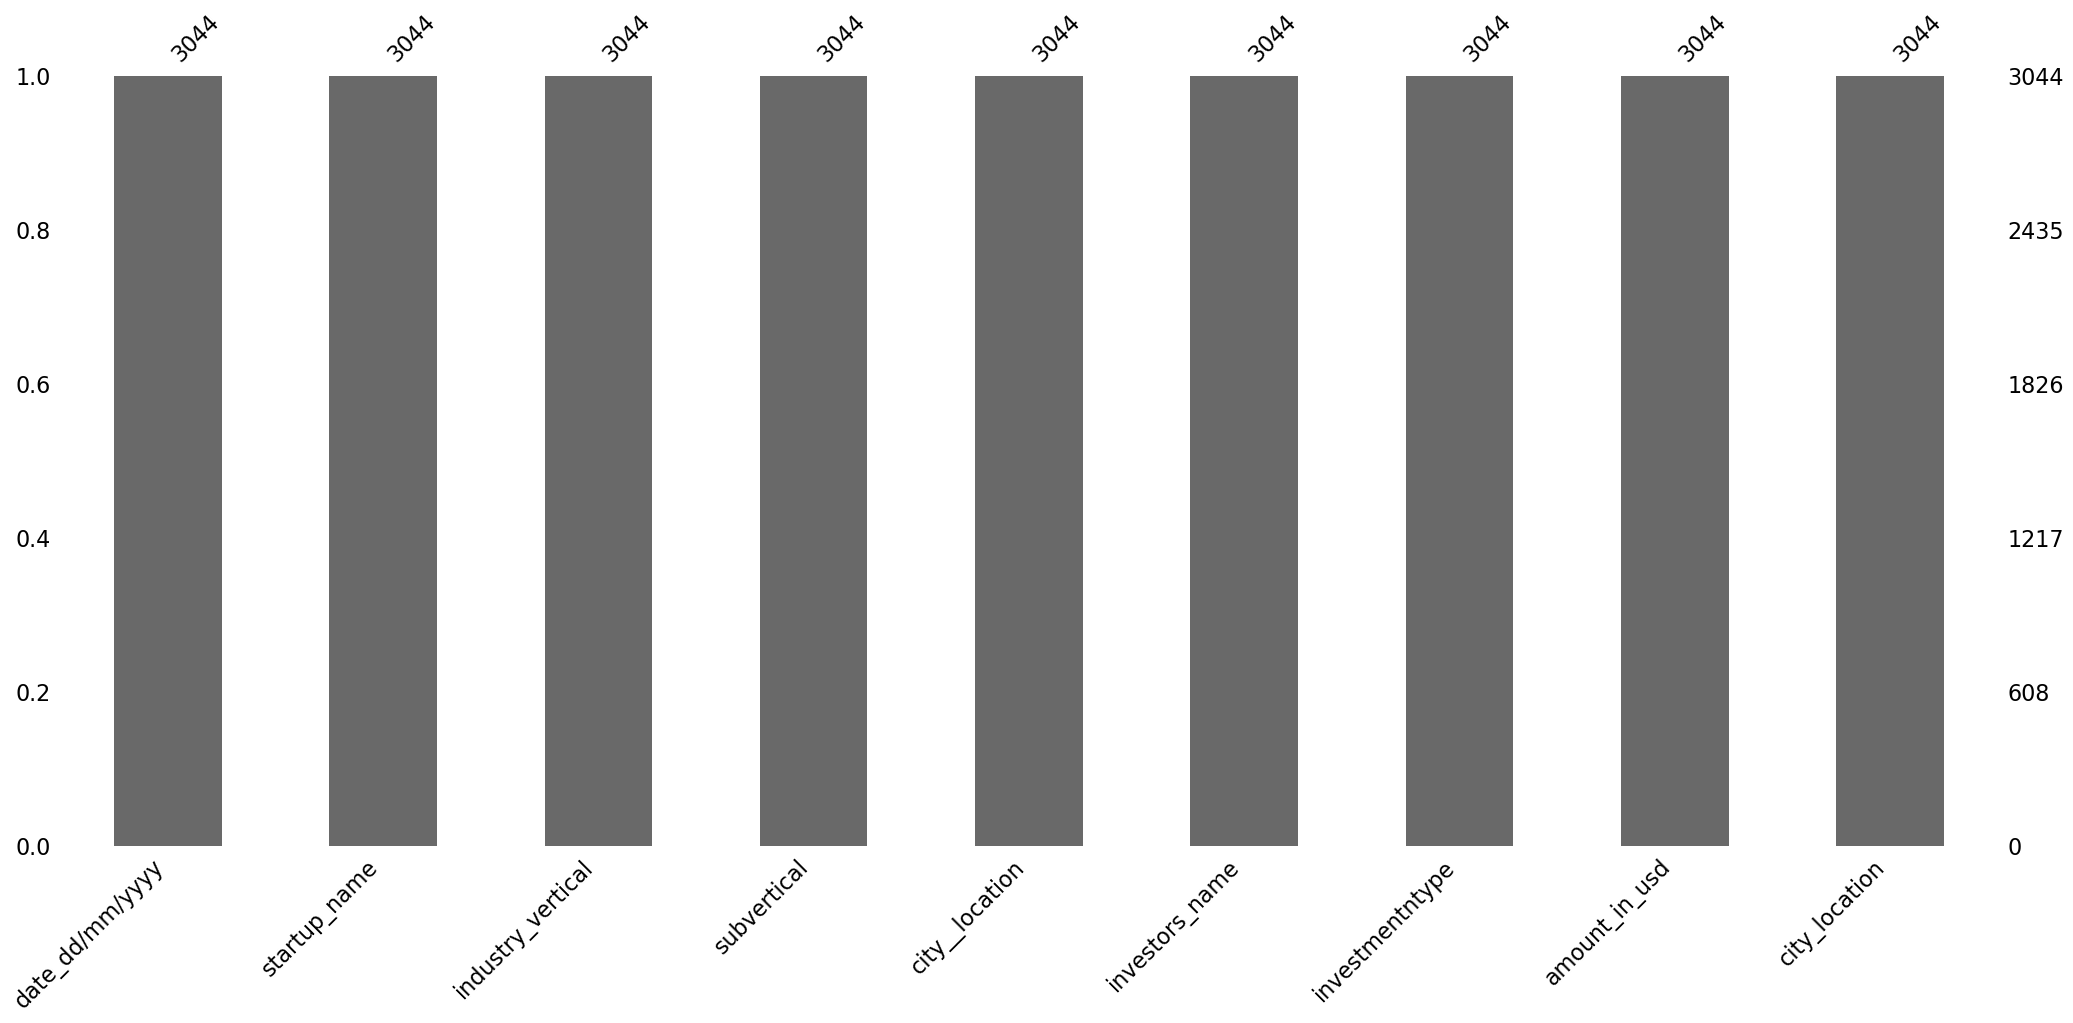

In [11]:
import missingno as msno
msno.bar(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_dd/mm/yyyy    3044 non-null   datetime64[ns]
 1   startup_name       3044 non-null   object        
 2   industry_vertical  3044 non-null   object        
 3   subvertical        3044 non-null   object        
 4   city__location     3044 non-null   object        
 5   investors_name     3044 non-null   object        
 6   investmentntype    3044 non-null   object        
 7   amount_in_usd      3044 non-null   float64       
 8   city_location      3044 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 214.2+ KB


In [13]:
# Save the preprocessed dataset to a CSV file without the index
df.to_csv("preprocessed_dataset.csv", index=False, header=True)

# **Data Visualization**

## **Funding Trends Over Time: Funding amount trends over months or years.**

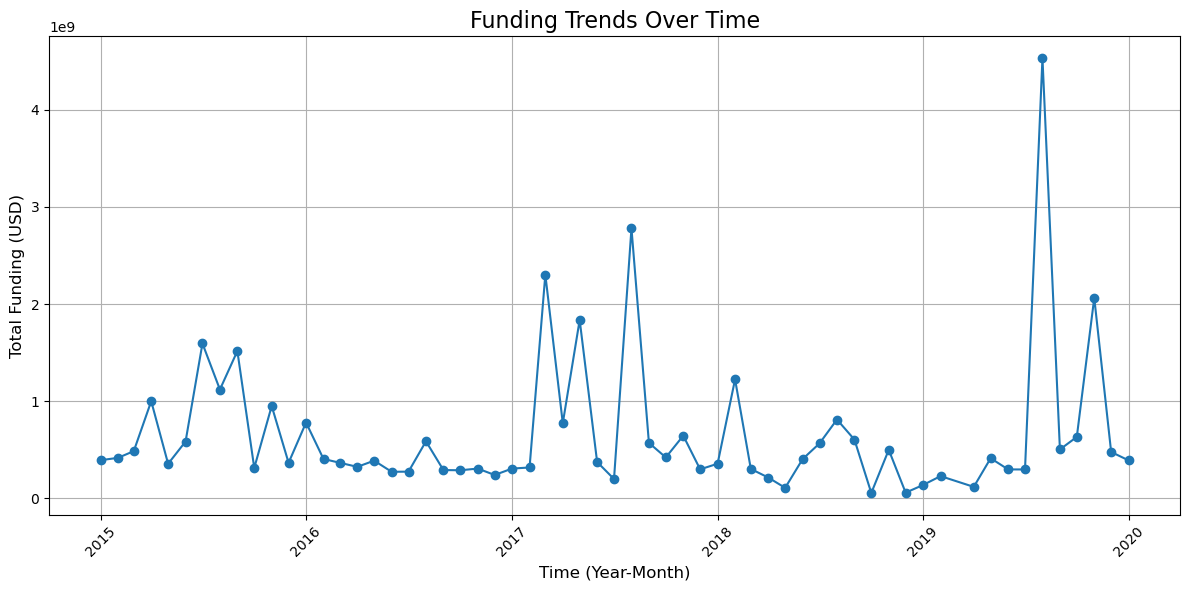

In [16]:
# Extract year and month
df['year_month'] = df['date_dd/mm/yyyy'].dt.to_period('M')

# Aggregate funding amount by year-month
funding_trends = df.groupby('year_month')['amount_in_usd'].sum().reset_index()

# Convert the 'year_month' back to datetime for plotting
funding_trends['year_month'] = funding_trends['year_month'].dt.to_timestamp()

# Plot the funding trends
plt.figure(figsize=(12, 6))
plt.plot(funding_trends['year_month'], funding_trends['amount_in_usd'], marker='o', linestyle='-')
plt.title('Funding Trends Over Time', fontsize=16)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Total Funding (USD)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Top Industries by Funding: Total funding per industry vertical.**

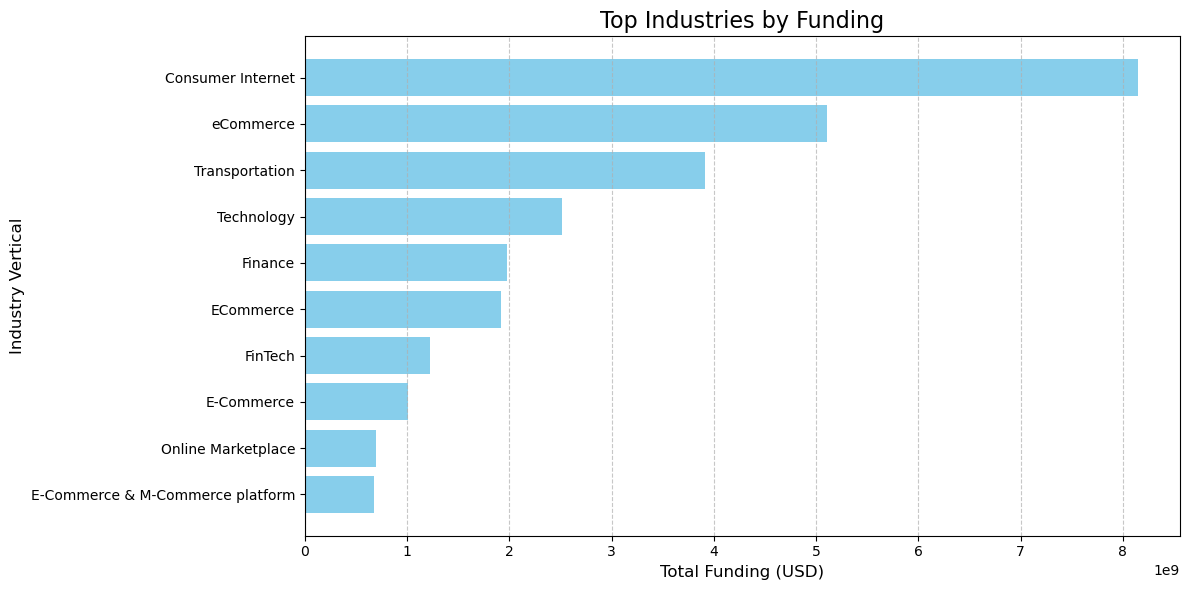

In [18]:
# Group by 'industry_vertical' and calculate total funding
industry_funding = df.groupby('industry_vertical')['amount_in_usd'].sum().reset_index()

# Sort by total funding in descending order
industry_funding = industry_funding.sort_values(by='amount_in_usd', ascending=False)

# Select top 10 industries for visualization
top_industries = industry_funding.head(10)

# Plotting a horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_industries['industry_vertical'], top_industries['amount_in_usd'], color='skyblue')
plt.xlabel('Total Funding (USD)', fontsize=12)
plt.ylabel('Industry Vertical', fontsize=12)
plt.title('Top Industries by Funding', fontsize=16)
plt.gca().invert_yaxis()  # Invert the y-axis to show the top industry at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Top 5 Investment Type Distribution: Proportions of investment types (e.g., seed funding, Series A).**

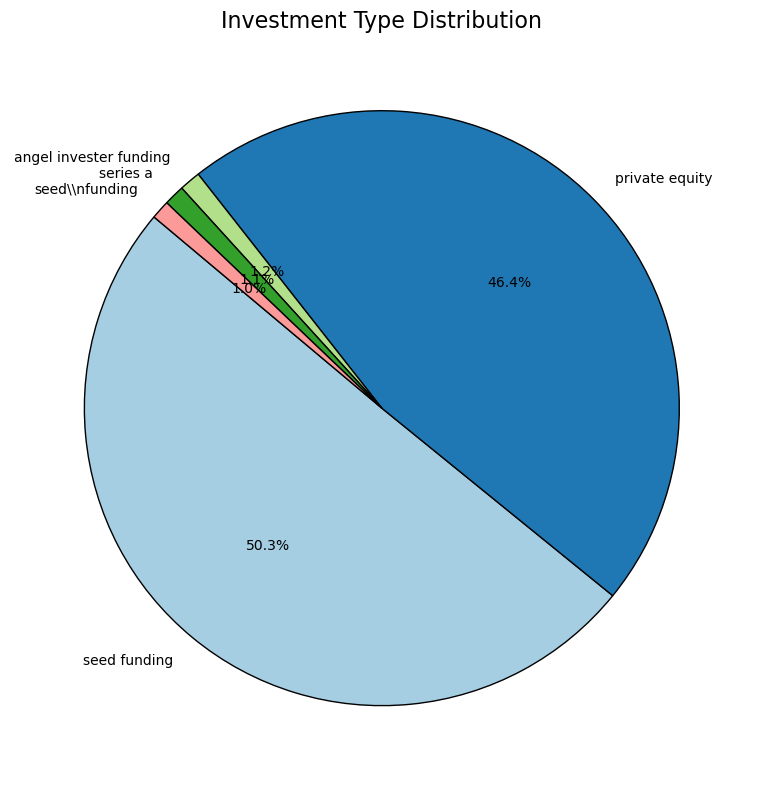

In [20]:
# Group the data by 'investmentntype' and count occurrences
investment_type_counts = df['investmentntype'].value_counts().nlargest(5)

# Plotting a pie chart
plt.figure(figsize=(8, 8))
colors = plt.cm.Paired(range(len(investment_type_counts)))  # Use a colormap for colors

plt.pie(
    investment_type_counts,
    labels=investment_type_counts.index,
    autopct='%1.1f%%',  # Display percentages
    startangle=140,     # Start the pie chart at a specific angle
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Investment Type Distribution', fontsize=16)
plt.tight_layout()
plt.show()

## **Top Cities for Startups**

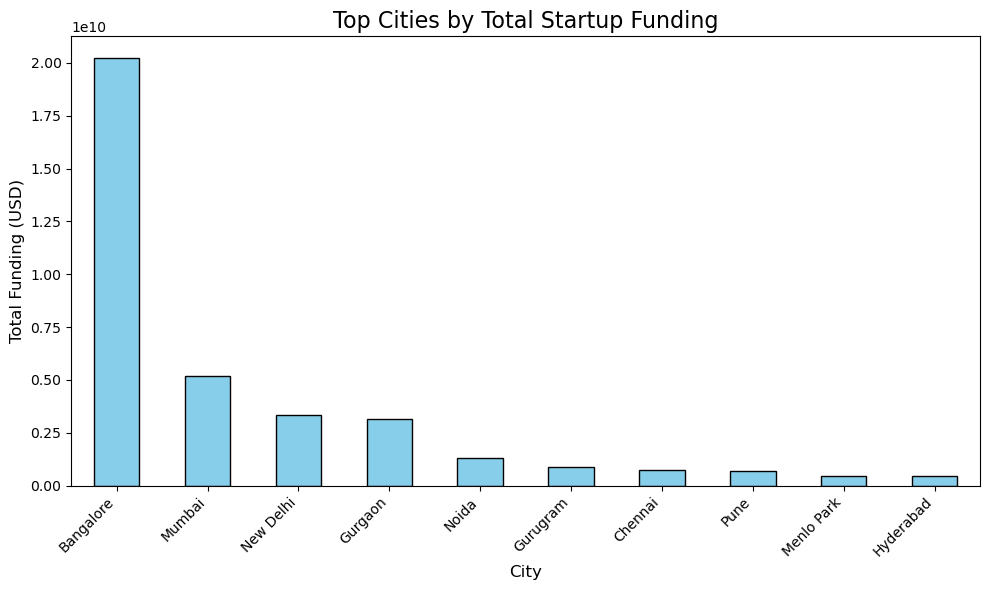

In [22]:
# Grouping data by 'city_location' and calculating the total funding
city_funding = df.groupby('city_location')['amount_in_usd'].sum().sort_values(ascending=False).head(10)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
city_funding.plot(kind='bar', color='skyblue', edgecolor='black')

# Customizing the chart
plt.title('Top Cities by Total Startup Funding', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Total Funding (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

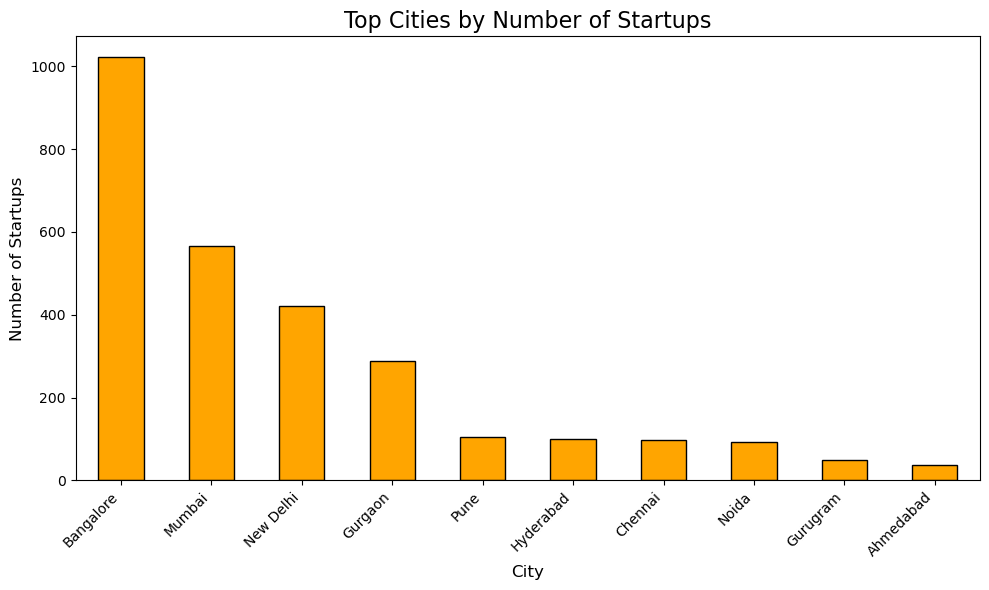

In [23]:
# Grouping data by 'city_location' and counting the number of startups
city_startups = df['city_location'].value_counts().head(10)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
city_startups.plot(kind='bar', color='orange', edgecolor='black')

# Customizing the chart
plt.title('Top Cities by Number of Startups', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Startups', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

## **Top-Funded Startups**

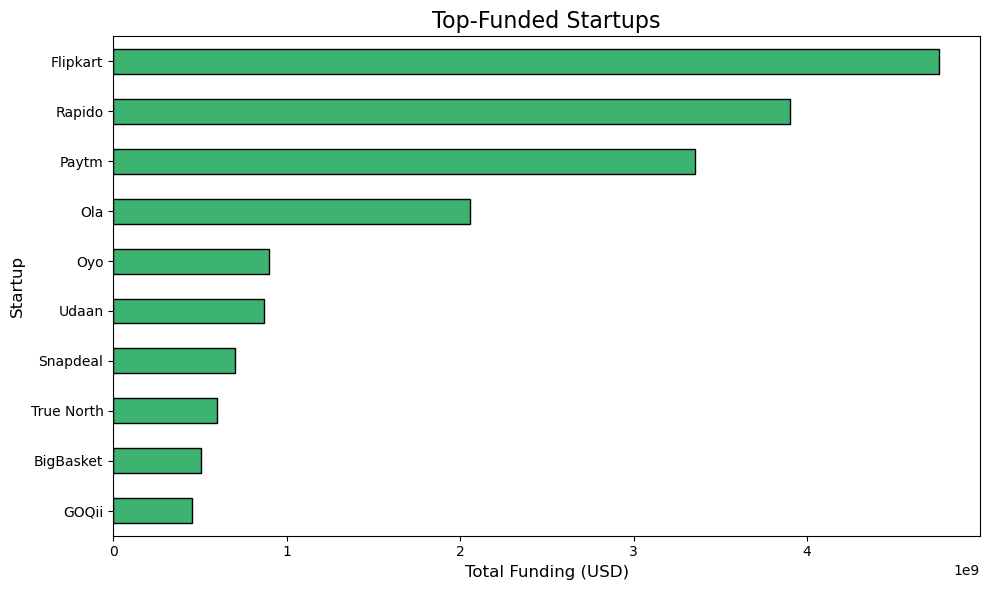

In [25]:
# Group data by 'startup_name' and calculate the total funding for each
top_funded_startups = (
    df.groupby('startup_name')['amount_in_usd']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plotting a horizontal bar chart
plt.figure(figsize=(10, 6))
top_funded_startups.plot(kind='barh', color='mediumseagreen', edgecolor='black')

# Customizing the chart
plt.title('Top-Funded Startups', fontsize=16)
plt.xlabel('Total Funding (USD)', fontsize=12)
plt.ylabel('Startup', fontsize=12)
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest-funded startup on top
plt.tight_layout()

plt.show()

## **Funding Distribution**

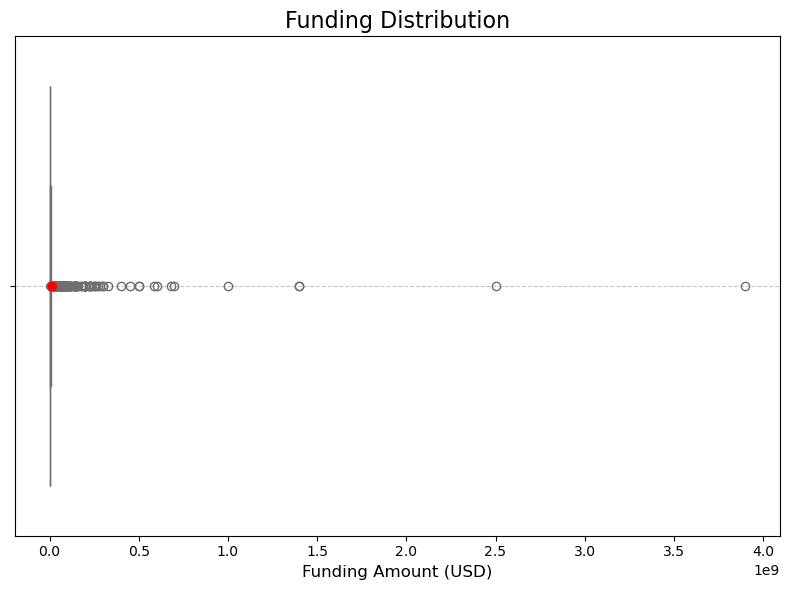

In [27]:
# Setting up the plot
plt.figure(figsize=(8, 6))

# Creating the boxplot
sns.boxplot(
    data=df, 
    x='amount_in_usd', 
    color='skyblue',
    showmeans=True,  # Show the mean in the boxplot
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)

# Customizing the plot
plt.title('Funding Distribution', fontsize=16)
plt.xlabel('Funding Amount (USD)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Displaying the plot
plt.show()

## **Investors with the most deals**

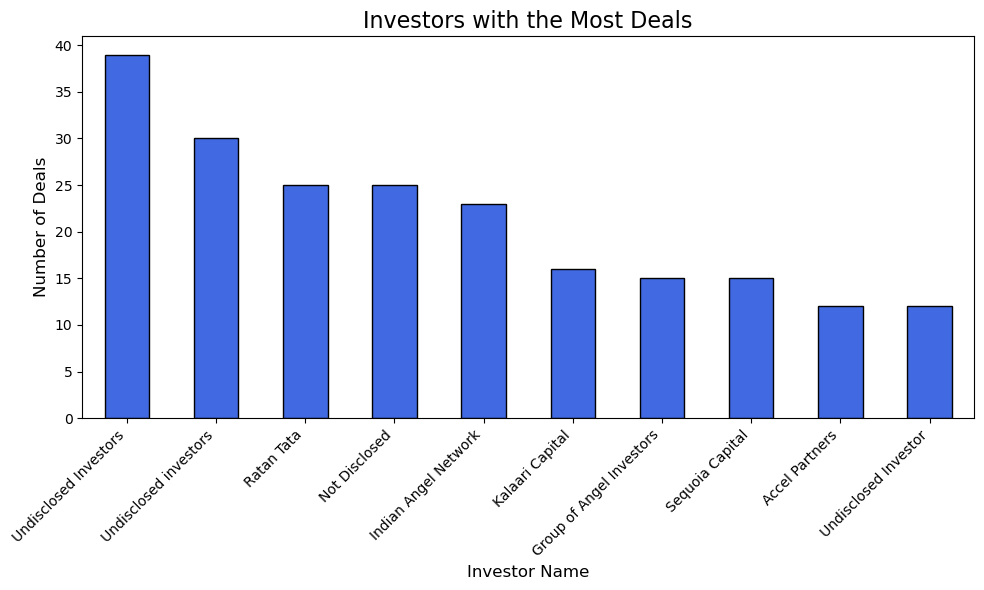

In [29]:
# Group by 'investors_name' and count the number of investments
top_investors = (
    df['investors_name']
    .value_counts()
    .head(10)  # Top 10 investors
)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
top_investors.plot(kind='bar', color='royalblue', edgecolor='black')

# Customizing the chart
plt.title('Investors with the Most Deals', fontsize=16)
plt.xlabel('Investor Name', fontsize=12)
plt.ylabel('Number of Deals', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate investor names for better visibility
plt.tight_layout()

# Display the plot
plt.show()

## **Industry wise funding trends over time**

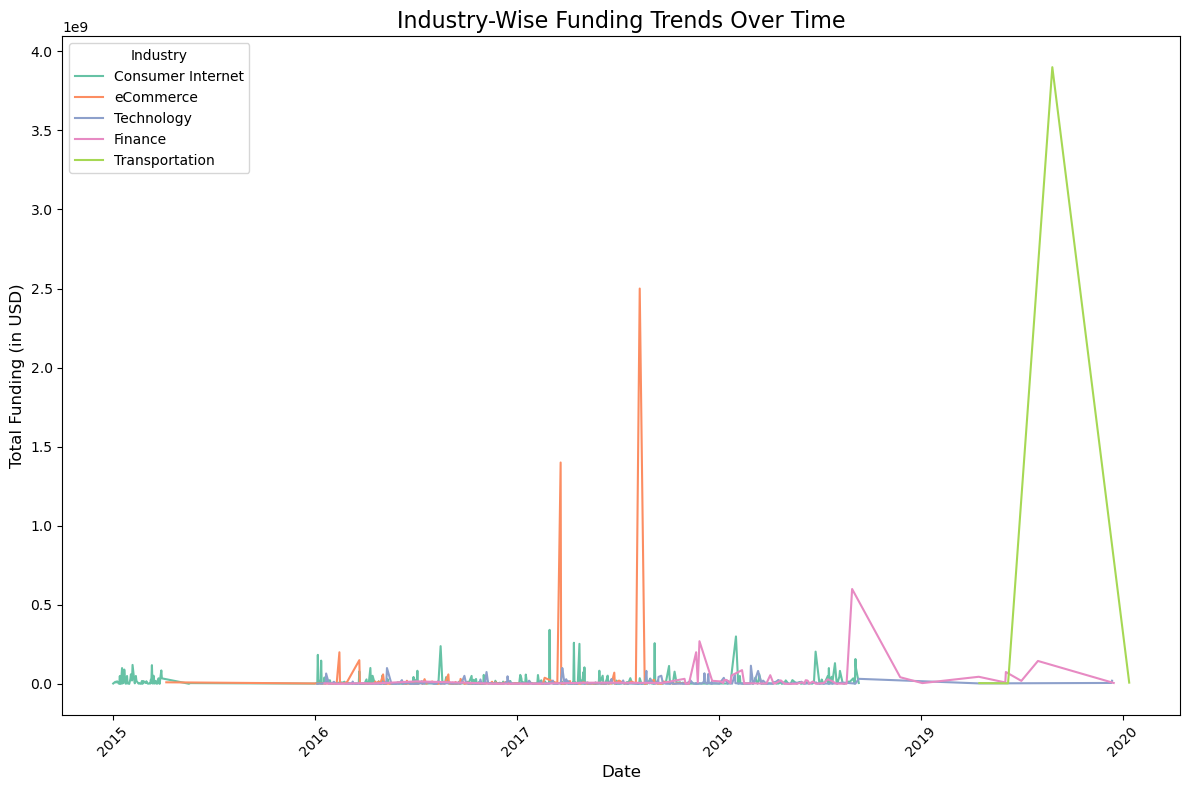

In [31]:
# Grouping data by date and industry and summing the funding amounts
industry_trends = (
    df.groupby(['date_dd/mm/yyyy', 'industry_vertical'])['amount_in_usd']
    .sum()
    .reset_index()
)

# Filtering to show only the top 5 industries by total funding
top_industries = (
    df.groupby('industry_vertical')['amount_in_usd']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Filtering the dataset for the top 5 industries
industry_trends = industry_trends[industry_trends['industry_vertical'].isin(top_industries)]

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=industry_trends,
    x='date_dd/mm/yyyy',
    y='amount_in_usd',
    hue='industry_vertical',
    palette='Set2'
)

# Customizing the plot
plt.title('Industry-Wise Funding Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Funding (in USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Industry', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


## **Startup success by Sub-vertical**

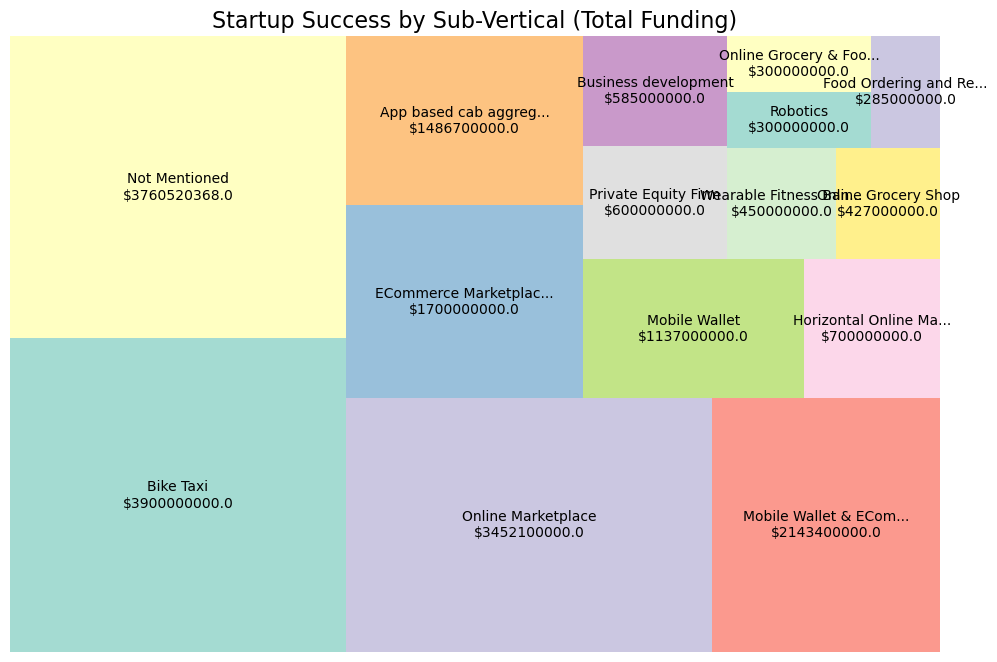

In [33]:
# Grouping data by sub-vertical and summing the funding amounts
subvertical_funding = (
    df.groupby('subvertical')['amount_in_usd']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Limiting to the top 15 sub-verticals for readability
top_subverticals = subvertical_funding.head(15)

# Preparing data for the treemap
sizes = top_subverticals['amount_in_usd']
labels = (
    top_subverticals['subvertical']
    .apply(lambda x: x if len(x) <= 20 else x[:20] + '...')  # Truncate long labels
    + '\n$' + top_subverticals['amount_in_usd'].round(2).astype(str)
)

# Plotting the treemap
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=sizes,
    label=labels,
    alpha=0.8,
    color=plt.cm.Set3.colors,
    text_kwargs={'fontsize': 10}  # Reduce font size
)

# Customizing the plot
plt.title('Startup Success by Sub-Vertical (Total Funding)', fontsize=16)
plt.axis('off')  # No axis for treemap

# Show the plot
plt.show()


## **City vs Funding vs Industries**

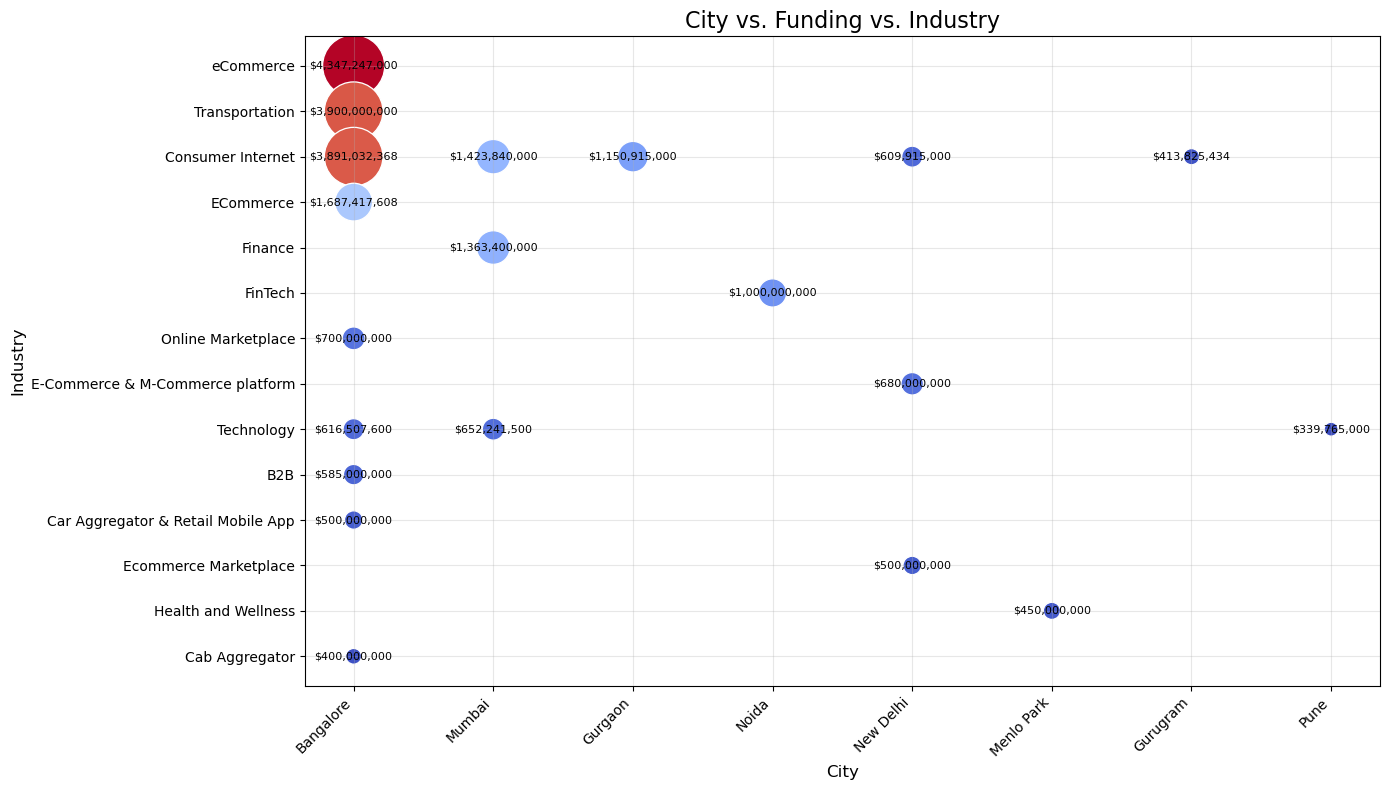

In [35]:
# Grouping data by 'city_location' and 'industry_vertical'
city_industry_funding = (
    df.groupby(['city_location', 'industry_vertical'])['amount_in_usd']
    .sum()
    .reset_index()
)

# Limiting to top 20 city-industry combinations for readability
top_city_industry = city_industry_funding.nlargest(20, 'amount_in_usd')

# Plotting the bubble chart
plt.figure(figsize=(14, 8))
bubble_plot = sns.scatterplot(
    data=top_city_industry,
    x='city_location',
    y='industry_vertical',
    size='amount_in_usd',
    hue='amount_in_usd',
    palette='coolwarm',
    sizes=(100, 2000),  # Bubble size range
    legend=False,
)

# Customizing the plot
plt.title('City vs. Funding vs. Industry', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Industry', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for clarity
plt.grid(alpha=0.3)

# Annotating each bubble with funding amount
for i in range(top_city_industry.shape[0]):
    plt.text(
        x=top_city_industry['city_location'].iloc[i],
        y=top_city_industry['industry_vertical'].iloc[i],
        s=f"${top_city_industry['amount_in_usd'].iloc[i]:,.0f}",
        fontsize=8,
        ha='center',
        va='center',
        color='black',
    )

# Displaying the plot
plt.tight_layout()
plt.show()